## Projeto em construção...

## Sumário

- [1.Importação das Bibliotecas](#1.-Importação-das-Bibliotecas)
- [2. Preparação dos Dados](#2.-Preparação-dos-Dados)
- [3. Análise Exploratória de Dados (AED)](#3.-Análise-Exploratória-de-Dados-(AED))
- [4. Modelagem - Deep Learning](#4.-Modelagem---Deep-Learning)
- [999. Referências](#999.-Referências)

# 1. Importação das Bibliotecas

In [135]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns # install the latest version !pip install -U seaborn
sns.set_style('darkgrid')

# ML libraries
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import prince # pip install prince
from xgboost import XGBRegressor #pip3 install xgboost

# 2. Preparação dos Dados

In [136]:
# load the data
data = pd.read_csv('./CoversBR_metadata.csv', delimiter=';')
data.head()

,work_id,Music_Name,track_id,Artist_Name,Source,Genre_ECAD,Recording_Version,Duration,Fs,MBID,ISWC,ISRC,Country,Year
0,1,ADMIRAVEL GADO NOVO,19629,CASSIA ELLER,CD,ND,STUDIO,00:04:35.07,11025,8311499a-4e40-4afc-a826-6725d8454851,T0391535844,BRPGD9600090,BR,96
1,1,ADMIRAVEL GADO NOVO,23880,ZE RAMALHO,CD,ND,STUDIO,00:05:06.69,11025,1ec54f25-7525-480a-b7fa-4c79fc2ee05f,T0391535844,BRBMG9700282,BR,97
2,1,ADMIRAVEL GADO NOVO,579191,BIQUINI CAVADAO,IMPORTACAO,ND,STUDIO,00:04:21.77,11025,880622cf-96fd-4211-850f-9f914a5244c6,T0391535844,BRSME9400075,BR,94
3,1,ADMIRAVEL GADO NOVO,705173,OSWALDO MONTENEGRO,CD,ND,STUDIO,00:04:57.23,11025,23d08080-8113-47ea-b712-65acf448252f,T0391535844,BRABZ0300234,BR,03
4,1,ADMIRAVEL GADO NOVO,2164817,CASSIA ELLER,ND,ND,STUDIO,00:02:51.96,11025,ND,T0391535844,BRMCA9000102,BR,90


# 3. Análise Exploratória de Dados (AED)

In [137]:
# 1. #rows vs. #columns
data.shape

(102298, 14)

**Temos um dataset com 102.298 ocorrências (exemplos) e 14 características/features (colunas), sendo uma delas, o rótulo/label (saída esperada).**

In [138]:
# 2. data types
data.dtypes

work_id               int64
Music_Name           object
track_id              int64
Artist_Name          object
Source               object
Genre_ECAD           object
Recording_Version    object
Duration             object
Fs                    int64
MBID                 object
ISWC                 object
ISRC                 object
Country              object
Year                 object
dtype: object

**Artist_Name é o nosso label; Duration e Year, que foram obtidos como object, serão convertidos para o tipo de dado correspondente ao tempo de música e ao ano, respectivamente.**

In [139]:
# 3. convert 'Duration' and Year' to datetime and show a few rows
data['Duration'] = pd.to_datetime(data['Duration'], format='%H:%M:%S.%f', errors='coerce').dt.time # NaT for invalid Duration values
data['Year'] = pd.to_datetime(data['Year'], format='%y', errors='coerce') # NaT for invalid Year values

data['Year'] = data['Year'].mask(data['Year'].dt.year > 2020, 
                                         data['Year'] - pd.offsets.DateOffset(years=100)) # Year goes up to 2020


data.sample(5)

,work_id,Music_Name,track_id,Artist_Name,Source,Genre_ECAD,Recording_Version,Duration,Fs,MBID,ISWC,ISRC,Country,Year
31311,118257,TREM DE FERRO,112944,OLIVIA HIME/TOM JOBIM,CAPTACAO RADIO,ND,STUDIO,00:02:14,11025,ND,T0393488533,ND,ND,NaT
74996,7046233,SLUT LIKE YOU,2640217,PINK,CD,ND,STUDIO,00:03:41.960000,11025,ND,T9089473494,USRC11200789,US,2012-01-01
24893,35968,SACO CHEIO,315415,ALMIR GUINETO,CAPTACAO RADIO,ND,STUDIO,00:03:19,11025,8fe3cdd5-381a-4ab6-8943-b9b3d6cabb4b,T0390506736,ND,BR,NaT
76142,7627633,DOSE DE PAIXAO,3242168,DURVAL & DAVI,CAPTACAO RADIO,ND,STUDIO,00:03:56,11025,ND,T0393329286,BRWMB9702332,BR,1997-01-01
88670,13472785,BOM DEMAIS DA CONTA,3094325,HENRIQUE & HERNANE,CD,ND,STUDIO,00:02:59.990000,11025,ND,T0392478179,BRWMB0201562,BR,2002-01-01


**Existem exemplos com valores inválidos/missing values/em branco/não preenchidos/NaNs/NaTs, que poderão ser tratados nos próximos passos.**

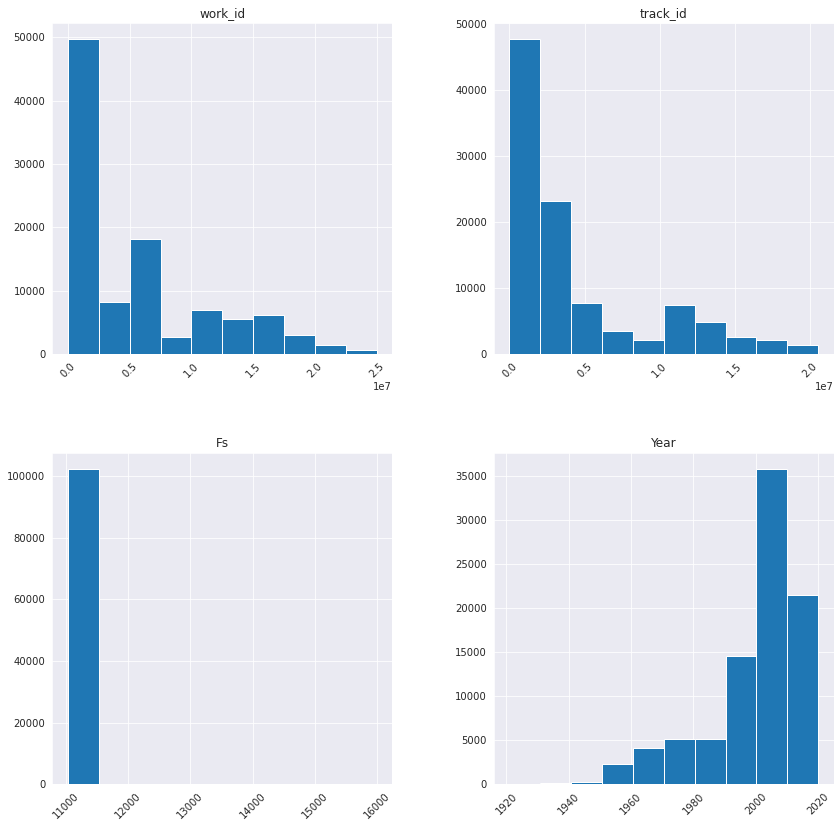

In [140]:
# 4. plot each numeric feature ----- *********userful to detect outliers*********
data.hist(figsize=(14,14), xrot=45)
plt.show()

**3 features são numéricas:**
1. Fs: frequência sonora da música em Hz (indo de ~11k até 16k, sendo esta correspondente a possíveis pontos fora da curva - outliers);
2. track_id: número identificador da música;
3. work_id: número identificador do grupo de cover, também chamado de clique (click, em inglês).

In [141]:
# 5. summary statistics of the numerical features
data.describe().T

,count,mean,std,min,25%,50%,75%,max
work_id,102298.0,5.165103e+06,6.015939e+06,1.0,40253.00,2835847.0,7788684.00,24998809.0
track_id,102298.0,4.452356e+06,4.886335e+06,15.0,1301414.25,2116795.0,6001035.75,20563324.0
Fs,102298.0,1.102763e+04,1.142731e+02,11025.0,11025.00,11025.0,11025.00,16000.0


**As medidas descritas sobre as features numéricas nos mostram:**

1. Fs: o espectro de ondas sonoras vai de 11.025,0 a 16.000,0, sendo pelo menos 75% decaindo sobre um Fs de 11.025; todos os exemplos aparentam estar preenchidos corretamente (102.298). 
2. track_id: todos os exemplos estão preenchidos nas 102.298 linhas (exemplos), começando em 15 e terminando em 20.563.324.
3. work_id: todos os exemplos estão preenchidos nas 102.298 linhas, começando em 1 e terminando em 24.998.809.

Sabe-se que a relação entre as músicas e os grupos de covers é a seguinte: existem 102.298 músicas, distribuídas em 26.366 grupos de covers. Isso implica que os ids dessas features não possuem uma relação unívoca, ou seja, a primeira track (música) não corresponde ao id 1, assim como o último work (grupo de cover) não corresponde ao id 26.366. Talvez, os ids tenham sido gerados de forma aleatória.

In [142]:
# 6. summary statistics of the categorical features
data.describe(include=['object', 'datetime']) # first and last values refers just to Year (datetime column)

<ipython-input-142-38a28da91c82>:2: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe(include=['object', 'datetime']) # first and last values refers just to Year (datetime column)


,Music_Name,Artist_Name,Source,Genre_ECAD,Recording_Version,Duration,MBID,ISWC,ISRC,Country,Year
count,102298,102298,102298,102298,102298,102298,102298,102298,102298,102298,88849
unique,23776,23432,4,48,38,25752,30722,15889,88863,51,97
top,1. ALLEGRO,ELVIS PRESLEY,IMPORTACAO,ND,STUDIO,00:03:00,ND,ND,ND,BR,2003-01-01 00:00:00
freq,183,932,44623,98128,80369,306,51488,34976,13372,41063,4360
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1921-01-01 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-01-01 00:00:00


**As demais 11 features são categóricas (incluindo uma, Year, de data):**

1. Music_Name: possui diversos valores repetidos, mas todos os exemplos estão preenchidos. A música com cover mais comum possui 183 entradas e contém em seu nome o texto "1. ALLEGRO".
2. Artist_Name: existem aproximadamente 23 mil artistas diferentes. O cover mais comum é do cantor Elvis Presley, com 932 entradas.
3. Source: há somente 4 fontes de gravação dos covers, sendo a mais comum - importação.
4. Genre_ECAD: existem 48 gêneros musicais distintos (baseados no Escritório Central de Arrecadação e Distribuição - ECAD).
5. Recording_Version: existem 38 versões de gravação diferentes, sendo a de estúdio, a mais comum (80.369 entradas).
6. Duration: o tempo mais comum das músicas é o de 3 minutos de duração. Este tempo está relacionado com as conhecidas "versões de rádio".
7. MBID: da mesma forma que há músicas que se repetem, há diversos exemplos com o identificador MusicBrainz (MBID) repetido.
8. ISWC: este ID único aparece repetido (diversas vezes), porque há registros da mesma música (várias vezes) no dataset.
9. ISRC: este ID, que identifica unicamente uma gravação, pode aparecer repetido devido a mais de uma entrada do mesmo cover no dataset.
10. Country: há músicas de diversos países, sendo o Brasil o país com maior número de registros (41.063). Ainda não se pode afirmar se são 51 países distintos sem antes analisar os exemplos com mais cuidado.
11. Year: com 97 registros, temos covers de músicas do ano de 1921 a 2020.

**Como descrito nas informações oficiais do dataset, as seguintes features possuem todos os valores informados:**

- work_id
- track_id
- Music_Name
- Artist_Name
- Duration

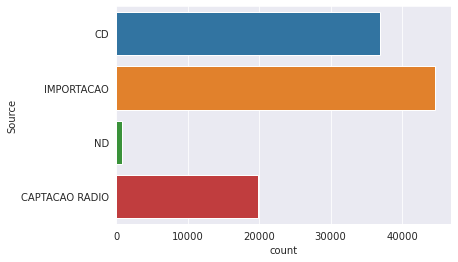

In [143]:
# 7. explore Source feature
sns.countplot(y='Source', data=data)
plt.show()

**A primeira feature a ser analisada em mais detalhes é a *Source*, que contém 4 classes distintas:**

Percebe-se que existem entradas **ND**, que são aquelas que não estão dentre CD, importação e captação de rádio.

In [144]:
# 8. explore Genre_ECAD feature
data['Genre_ECAD'].unique()

array(['ND', 'PAGODE', 'SAMBA CANCAO', 'MPB', 'SAMBA', 'SERTANEJO',
       'BOSSA NOVA', 'FORRO', 'TANGO', 'POP MUSIC', 'VANEIRAO',
       'ROMANTICO', 'ROCK', 'SAMBA ENREDO', 'HINO', 'TIMBALADA', 'FREVO',
       'MAXIXE', 'TOADA', 'EVANGELICA', 'DANCE MUSIC', 'BAIAO', 'CHORO',
       'VALSA', 'FUNK', 'FOX-TROT', 'CLASSICA', 'BOLERO', 'HEAVY METAL',
       'MARCHA-RANCHO', 'XOTE', 'AXE MUSIC', 'GOSPEL', 'RELIGIOSO', 'RAP',
       'MARCHA', 'INSTRUMENTAL', 'REGGAE', 'BALADA', 'LAMBADA', 'CANCAO',
       'CATOLICO', 'CALYPSO', 'WORLD MUSIC', 'REGIONAL', 'SOUL', 'SACRA',
       'OUTROS'], dtype=object)

**A segunda feature a ser explorada é *Genre_ECAD*, que contém 48 classes distintas:**

Percebe-se que existem entradas **ND**, que correspondem a gêneros desconhecidos ou não informados. Há também a categoria **outros**. Percebe-se que há covers, também, de músicas **instrumentais** e eletrônicas como **dance music**, que são gêneros que não apresentam necessariamente vocal, mas tão somente instrumentos musicais/eletrônicos.

In [145]:
# 9. explore Recording_Version feature
data['Recording_Version'].unique()

array(['STUDIO', 'LIVE (AO VIVO)', 'REMIX', 'TAPE', 'ACUSTICO',
       'ACUSTICO MTV', 'UNPLUGGED (ACUSTICO)', 'ND', 'ACUSTICO AO VIVO',
       'RADIO REMIX', 'HOUSE EDIT', 'DVD', 'A CAPELA', 'RADIO VERSION',
       'STUDIO VERSION', 'NI', 'MTV AO VIVO', 'MIX', 'ALBUM', 'VHS',
       'VINHETA', 'MEME SUPER CLUB MIX 2002', 'POP MIX', 'EXTENDED MIX',
       'BIBLIOTECA', 'RADIO EDIT', 'ROCK VERSION', 'G-VO MIX', 'SURTO',
       'CLUB REMIX', 'PLAY BACK', 'RADIO MIX', 'LONG VERSION',
       'EDITED SLOW', 'EDIT MIX', 'XRS REMIX RADIO EDIT', 'LOUNGE MIX',
       'GROOVE MIX'], dtype=object)

**A terceira feature a ser explorada é *Recording_Version*, que contém 38 classes distintas:**

Nota-se entradas **ND**, também, para esta feature. Há diversas categorias inclusas na modalidade **ao vivo**, como **live** e **acústico ao vivo**. Conforme informações oficiais dos autores do dataset, as classes mais comuns dentre os covers gravados são: estúdio, ao vivo e remix. No próximo passo confirmamos isto por meio de um gráfico.

   Tipos de Gravação  Ocorrências
30            STUDIO        80369
14    LIVE (AO VIVO)        17504
28             REMIX         2765
20                ND          671
1           ACUSTICO          205
---


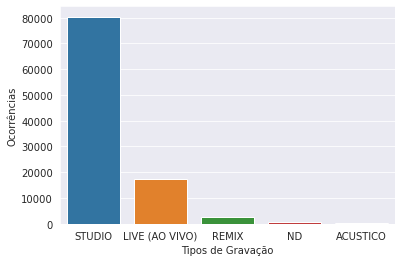

In [146]:
# 9.continuation. plot most frequent classes
recording_version = data[['Artist_Name', 'Recording_Version']].copy()
recording_version = recording_version.groupby(by=['Recording_Version']).count().reset_index()
recording_version_TOP = recording_version.sort_values('Artist_Name', ascending=False)
recording_version_TOP.rename(index=str, columns={'Recording_Version': 'Tipos de Gravação', 'Artist_Name': 'Ocorrências'}, inplace=True)
recording_version_TOP_5 = recording_version_TOP.head(5)

print(recording_version_TOP_5)
print('---')

# plot results
recording_version_TOP_5_plot = sns.barplot(x='Tipos de Gravação', y='Ocorrências', data=recording_version_TOP_5)

In [147]:
# 10. explore Duration feature
isNegativeHour = data['Duration'] < dt.time(hour=0) # are there negative hours?
isNegativeMinute = data['Duration'] <= dt.time(minute=0) # are there negative, or zero, minutes?

print(isNegativeHour.value_counts())
print('---')
print(isNegativeMinute.value_counts())

False    102298
Name: Duration, dtype: int64
---
False    102298
Name: Duration, dtype: int64


Gravação mais curta:  00:00:04.370000
Gravação mais longa:  00:38:19.600000
Gravação mais comum:  00:03:00
---


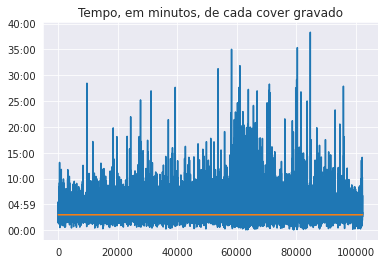

In [148]:
# 10.continuation. plot Duration distribution
print('Gravação mais curta: ', min(data['Duration']))
print('Gravação mais longa: ', max(data['Duration']))

examples_list = list(range(1, data.shape[0]+1))
y_dt = [dt.datetime.combine(dt.date.max, t) for t in data['Duration']]

# plot musics per duration
fig = plt.figure()
ax = fig.add_subplot(1,1,1) 
ax.yaxis.set_major_formatter(mdates.DateFormatter('%M:%S'))
music_duration_plot = plt.plot(examples_list, y_dt)

# get most frequent Duration class to draw and plot
uniques, counts = np.unique(y_dt, return_counts=True)
duration_most_frequent = uniques[np.argmax(counts)]
duration_most_frequent_list = [duration_most_frequent for i in range(len(examples_list))]

print('Gravação mais comum: ', duration_most_frequent.time())
print('---')

plt.plot(range(len(examples_list)), duration_most_frequent_list)
plt.title('Tempo, em minutos, de cada cover gravado')
plt.show()

**Ao explorar a quarta feature, *Duration*, que contém 25.752 classes distintas, temos que:**

Todas as classes contém valores de duração de música válidos. (Os valores tratados como inválidos são considerados como NaT.) Temos 102.298 exemplos (mesmo número de linhas do dataset) com valores iguais a NaT ou iguais a um tempo válido de hora:minuto:segundo.microsegundo.

A gravação mais curta dura poucos segundos e a mais longa possui quase 40 minutos. O gráfico exibido acima mostra a distribuição das músicas com relação ao tempo de gravação do cover. Há uma grande concentração de músicas com duração de aproximadamente 3 minutos.

In [149]:
# 11. explore Country feature

# first, let's review country list data table
data_country = pd.read_csv('CountryList_ISRC.csv', delimiter=';')
data_country.columns = ['ACRONYM', 'ACRONYM_BIGGER', 'Country']
data_country = data_country.dropna()
data_country.head(5)

# second, get the acronymns that doesn't exist
countries_cover_list = data['Country']
countries_ISRC_list_2_letter = data_country['ACRONYM']
countries_ISRC_list_3_letter = data_country['ACRONYM_BIGGER']

false_acronyms = [s for s in countries_cover_list if not any(xs in s for xs in countries_ISRC_list_2_letter) and not any(xs in s for xs in countries_ISRC_list_3_letter)]

print('False country acronyms:', set(false_acronyms))
print('---')

for false_acronym in set(false_acronyms):
    false_acronyms_count_condition = data['Country'][data['Country'] == false_acronym]
    false_acronyms_count = false_acronyms_count_condition.count()
    
    print(false_acronym + ' count = ' + str(false_acronyms_count))

False country acronyms: {'NDI', 'ND'}
---
NDI count = 1156
ND count = 8398


   Países  Ocorrências
7      BR        41063
49     US        28723
19     GB        10284
30     ND         8398
14     DE         4651
---


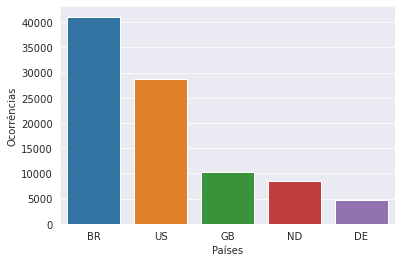

In [150]:
# 11.continuation. plot most frequent classes
countries = data[['Artist_Name', 'Country']].copy()
countries = countries.groupby(by=['Country']).count().reset_index()
countries_TOP = countries.sort_values('Artist_Name', ascending=False)
countries_TOP.rename(index=str, columns={'Country': 'Países', 'Artist_Name': 'Ocorrências'}, inplace=True)
countries_TOP_5 = countries_TOP.head(5)

print(countries_TOP_5)
print('---')

# plot results
countries_TOP_5_plot = sns.barplot(x='Países', y='Ocorrências', data=countries_TOP_5)

**Ao explorar a quinta feature, *Country*, que contém 51 classes distintas, temos que:**

- Os exemplos representam siglas dos países dos covers, em inglês, de acordo com o *CountryList_ISRC.csv*, disponibilizado pelos autores do dataset de covers.
- Na descrição oficial do dataset, temos 44 países, então tivemos de tratar siglas fora de contexto (que não representam países - problemas/ruídos na construção do dataset).
- Existem 8.398 exemplos com a entrada **ND** que serão considerados como **outros** países.
- Existem 1.156 exemplos com a entrada **NDI** que não corresponde a nenhum país listado.
- Brasil, Estados Unidos e Reino Unido estão dentre os países com mais registros de cover.

Número de músicas por feature (que não possui todos os casos informados):

{'Genre': 4170, 'ISRC': 88926, 'ISWC': 67322, 'MBID': 50810, 'Country': 92744, 'Year': 88849}


,Feature,#exemplos,Representatividade (%)
4,Country,92744,90.660619
1,ISRC,88926,86.928386
5,Year,88849,86.853115
2,ISWC,67322,65.809693
3,MBID,50810,49.668615
0,Genre,4170,4.076326


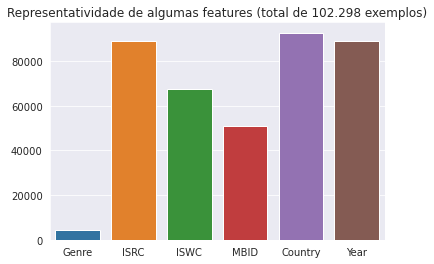

In [151]:
# aggregate some data: count another occurrences (non ND, NaN, values)
dict_ocurr = {}

# songs by Genre_ECAD
songs_by_genre = data['Genre_ECAD'][data['Genre_ECAD'] != 'ND'].count()
dict_ocurr['Genre'] = songs_by_genre

# songs by ISRC
songs_by_ISRC = data['ISRC'][data['ISRC'] != 'ND'].count()
dict_ocurr['ISRC'] = songs_by_ISRC

# songs by ISWC
songs_by_ISWC = data['ISWC'][data['ISWC'] != 'ND'].count()
dict_ocurr['ISWC'] = songs_by_ISWC

# songs by MBID
songs_by_MBID = data['MBID'][data['MBID'] != 'ND'].count()
dict_ocurr['MBID'] = songs_by_MBID

# songs by Country
songs_by_country = data['Country'][data['Country'] == 'NDI'].count()
songs_by_country = songs_by_country + data['Country'][data['Country'] == 'ND'].count()
dict_ocurr['Country'] = data['Country'].count() - songs_by_country

# songs by Year
songs_by_year = data['Year'].count()
dict_ocurr['Year'] = songs_by_year

print('Número de músicas por feature (que não possui todos os casos informados):')
print()
print(dict_ocurr)

# plot feature representativeness
features_representativeness_plot_x = list(dict_ocurr.keys())
features_representativeness_plot_y = list(dict_ocurr.values())

ocurr_data = pd.DataFrame(features_representativeness_plot_x,columns=['#Songs'])
ocurr_data['Occurrences'] = features_representativeness_plot_y

features_representativeness_plot = sns.barplot(x=features_representativeness_plot_x, 
                                                y=features_representativeness_plot_y, 
                                                data=ocurr_data).set_title('Representatividade de algumas features (total de 102.298 exemplos)')

# print features ratio
ratio_list = [ratio / data.shape[0] * 100 for ratio in features_representativeness_plot_y]

ratio_dataframe = pd.DataFrame(features_representativeness_plot_x,columns=['Feature'])
ratio_dataframe['#exemplos'] = features_representativeness_plot_y
ratio_dataframe['Representatividade (%)'] = ratio_list
ratio_dataframe = ratio_dataframe.sort_values('Representatividade (%)', ascending=False)
ratio_dataframe

**Ao agregar as variáveis categóricas, pontua-se o seguinte:**

As variáveis que não possuem todos os exemplos registrados (contém valores NDs/NaNs) variam em número de exemplos, consideravelmente, entre si.

Enquanto o gênero de apenas 4.170 (de 102.298) músicas, ou 4%, foram informados, quase todos os países, 92.744, ou 90%, foram registrados.

In [152]:
# aggregate some data: continuation

# songs per click
clicks = data[['track_id', 'work_id']].copy()
clicks = clicks.groupby(by=['work_id']).count().reset_index()
clicks_TOP = clicks.sort_values('track_id', ascending=False)

clicks_TOP.rename(index=str, columns={'work_id': 'ID do Cover', 'track_id': '# de músicas'}, inplace=True)
clicks_TOP_5 = clicks_TOP.head(5)
#clicks_TOP_5 = clicks_TOP.tail(5)
clicks_TOP_5

,ID do Cover,# de músicas
14681,5238551,76
14771,5240219,72
9983,2195919,69
12130,4357829,68
259,789,65


**Ao agregar as informações de cover e número de músicas, podemos perceber que uma pessoa pode ter feito entre 2 e 76 covers.**

In [153]:
# correlations matrix for the different numerical features
corrs = data.corr()
corrs

,work_id,track_id,Fs
work_id,1.000000,0.394979,-0.002792
track_id,0.394979,1.000000,0.034104
Fs,-0.002792,0.034104,1.000000


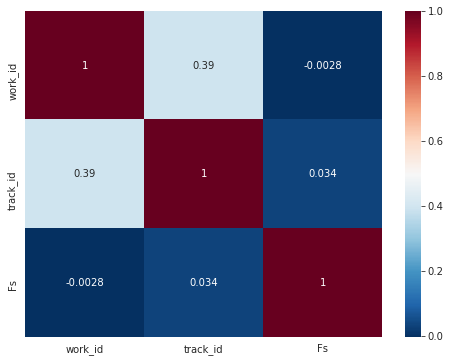

In [154]:
# heatmap of the correlations
plt.figure(figsize=(8,6))
sns.heatmap(corrs, cmap='RdBu_r', annot=True)
plt.show()

**Já com relação à correlação entre as variáveis numéricas:**

Há fraca correlação entre as variáveis numéricas. Afinal, não existe uma relação lógica entre frequência de uma música e a sua identificação ou ainda a identificação do grupo de cover que ela pertence. Ainda assim, pode-se notar uma correlação, mesmo que mínima, entre um cover (work_id) e uma track_id, pois o autor do cover pode ter feito o seu trabalho para mais de uma música diferente.

# 4. Abordagem 1 - Ensemble: Floresta Aleatória (FA)

A primeira etapa para a nossa primeira abordagem é realizar um pré-processamento dos dados segundo os seguintes procedimentos:

1. Tratar valores não disponíveis (NaNs).
2. Converter colunas datetime para numéricas (coluna Year, apenas).
3. Definir os atributos (features) de entrada do modelo.
4. Definir as classes de saída do modelo.

A segunda etapa consiste em implementar o modelo propriamente dito. Ressalta-se que a floresta aleatória é considerada um método *bagging*.

A terceira etapa consiste em implementar um novo modelo utilizando redução de dimensionalidade com a técnica Multiple Correspondence Analysis (continuação do pré-processamento) para verificar se é possível atingir performance e resultados melhores.

**Observação:** o atributo **Music_Name:** não será considerado durante a classificação. Do ponto de vista de computacional, esta string é capaz de estourar a memória e derrubar o kernel de execução deste projeto.

## 4.1. FA - Pré-processamento

In [155]:
# count NAN values
data.isnull().sum()

work_id                  0
Music_Name               0
track_id                 0
Artist_Name              0
Source                   0
Genre_ECAD               0
Recording_Version        0
Duration                 0
Fs                       0
MBID                     0
ISWC                     0
ISRC                     0
Country                  0
Year                 13449
dtype: int64

In [156]:
############## Deal with NANs - Year ##############
median_year = data['Year'].quantile(0.5, interpolation='midpoint')
print('Mediana de Year: ', median_year)

# fill NANs with median
data['Year'].fillna(median_year, inplace=True)

Mediana de Year:  2004-01-01 00:00:00


In [157]:
# recheck NAN
data.isnull().sum()

work_id              0
Music_Name           0
track_id             0
Artist_Name          0
Source               0
Genre_ECAD           0
Recording_Version    0
Duration             0
Fs                   0
MBID                 0
ISWC                 0
ISRC                 0
Country              0
Year                 0
dtype: int64

In [158]:
# convert Year to numeric type
data['Year'] = data.Year.astype(str).str[:4]
data['Year'] = data['Year'].astype(int)

In [159]:
# check the shape of pre-processed data
data.shape

(102298, 14)

In [160]:
# check the pre-processed data
data.sample()

,work_id,Music_Name,track_id,Artist_Name,Source,Genre_ECAD,Recording_Version,Duration,Fs,MBID,ISWC,ISRC,Country,Year
1505,626,JESUS SALVADOR,16733,ROBERTO CARLOS,CD,MPB,STUDIO,00:05:40.470000,11025,9d03f63e-e0e0-4fa8-ac04-acb25dded65b,T0390263678,ND,BR,2004


In [161]:
# define input/output
y = data.Artist_Name
coverSongIdentification_features = ['Source', 'Genre_ECAD', 'Recording_Version', 'Duration', 
                                    'MBID', 'ISWC', 'ISRC', 'Country', 'Year']           

X = data[coverSongIdentification_features]

# split data: train/validation
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=0, train_size=0.75, test_size=0.25)

# check data balancing
#y_train.value_counts()
#y_val.value_counts()

# check #examples output
#len(y_train)
#len(y_val)

# pre-processing - pipeline

# deal with numerical data
numerical_transformer = SimpleImputer(strategy='constant')

# deal with categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# make preprocessor to encode X
numerical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['int64', 'float64']]
categorical_cols = [cname for cname in X_train.columns if X_train[cname].dtype in ['object', 'datetime64[ns]']]

# encode y
y_label = preprocessing.LabelEncoder()
y_train = y_label.fit_transform(y_train)
y_val = y_label.fit_transform(y_val)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)])

## 4.2. FA - Modelagem

In [ ]:
print('Executando...')
# 'Bagging' for Random Forest
# 'Boosting' for Extreme Gradient Boosting
doEnsemble('Bagging')

Executando...


## 4.3. FA - Modelagem com Multiple Correspondence Analysis (MCA)

In [ ]:
# 'Bagging' for Random Forest; 'Boosting' for Extreme Gradient Boosting.
# n_components -> recommendation: n_components = 1 to 10
# X2 = features
preds_list = doEnsembleWithMCA('Bagging', 10, X2)
preds_list

## 4.4. FA - Plotar Componentes da MCA

In [ ]:
# best_n_components = number of MCA components of the best model
plotEnsembleWithMCA(3)

# 5. Abordagem 2 - Ensemble: Extreme Gradient Boosting

A segunda abordagem é uma alternativa para o uso de árvores de decisão. Neste caso, utilizaremos o Extreme Gradient Boosting, que utiliza o método Boosting com gradiente descendente. Este ensemble ajusta os modelos de árvores sequencialmente, em vez de simultaneamente, como é o caso do bagging realizado pelas florestas aleatórias.

O pré-processamento é o mesmo do utilizado na abordagem 1.

## 5.1. Boosting - Modelagem

In [ ]:
# 'Bagging' for Random Forest
# 'Boosting' for Extreme Gradient Boosting
doEnsemble('Boosting')

## 5.2. Boosting com MCA

In [ ]:
# 'Bagging' for Random Forest; 'Boosting' for Extreme Gradient Boosting.
# n_components -> recommendation: n_components = 1 to 10
# X2 = features
preds_list = doEnsembleWithMCA('Boosting', 10, X2)
preds_list

## 5.3. Boosting - Plotar Componentes da MCA

In [ ]:
# best_n_components = number of MCA components of the best model
plotEnsembleWithMCA(2)

# 6. Abordagem 3 - Deep Learning (DL)

**DOING...**

Em ambientes de produção pode não ser possível obter os dados sobre um cover como: gênero, ano, país, versão de gravação, etc. Neste caso, convém extrair características intrínsecas da música. Neste sentido, podemos extrair diversos componentes sonoros, como a onda sonora, de uma música e alimentar uma rede neural profunda.

In [ ]:
#TODO: verificar se a classe de saída está balanceada data['Artist_Name'].value_counts()

In [ ]:
#TODO: amostra de uma música (dentro da seção 2.)

# 998. Funções Utilizadas

In [ ]:
# Perform data classification with ensemble
# @method:  'Bagging' for Random Forest or 'Boosting' for Extreme Gradient Boosting
def doEnsemble(method):
    # choose model to define
    if method == 'Bagging':
        model = RandomForestRegressor(n_estimators=5, n_jobs=4, random_state=0) # my processor has 4 cores
    elif method == 'Boosting':
        model = XGBRegressor(n_estimators=10, learning_rate=0.05, n_jobs=4, random_state=0) # my processor has 4 cores

    # create a pipeline for the model
    my_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model', model)])

    # fit the model
    my_pipeline.fit(X_train, y_train)

    # predict validation data
    val_preds = my_pipeline.predict(X_val)

    # evaluate the model with MAE (measures accuracy for continuous variables)
    mae = mean_absolute_error(y_val, val_preds)
    print('Erro médio absoluto = %.2f' % mae)

    # evaluate the model with RMSE (measures accuracy for continuous variables)
    rmse = mean_squared_error(y_val, val_preds, squared=False)
    print('Raiz do Erro Quadrático Médio = %.2f' % rmse)

#============================================================================================

# Perform data classification with ensemble + MCA for dimensionality reduction 
# @method: 'Bagging' for Random Forest or 'Boosting' for Extreme Gradient Boosting
# @n_components: number of MCA components. Recommendation: n_components = 1 to 10
# @X2: features of the model
def doEnsembleWithMCA(method, n_components, X2):
    # split data: train/validation
    X_train_mca, X_val_mca, y_train_mca, y_val_mca = train_test_split(X2, y, random_state=0, train_size=0.75, test_size=0.25)

    MCA_N_COMPONENTS = n_components
    preds_list = list()

    for i in range(1, MCA_N_COMPONENTS+1):
        mca = prince.MCA(random_state=0, n_components=i)
        mca2 = prince.MCA(random_state=0, n_components=i)

        # encode X for train
        mca_train = mca.fit(X_train_mca)
        mca_train = mca.transform(X_train_mca)

        # encode X for validation
        mca_val = mca2.fit(X_val_mca)
        mca_val = mca2.transform(X_val_mca)

        # encode y for train
        y_label_mca = preprocessing.LabelEncoder()
        y_train_mca = y_label_mca.fit_transform(y_train_mca)

        # encode y for validation
        y_val_mca = y_label_mca.fit_transform(y_val_mca)

        if method == 'Bagging':
            model = RandomForestRegressor(n_estimators=5, n_jobs=4, random_state=0) # my processor has 4 cores
        elif method == 'Boosting':
            model = XGBRegressor(n_estimators=10, learning_rate=0.05, n_jobs=4, random_state=0) # my processor has 4 cores

        # fit the model
        model.fit(mca_train, y_train_mca)

        # predict with the model
        val_preds_mca = model.predict(mca_val)

        # calculate MAE
        mae = mean_absolute_error(y_val_mca, val_preds_mca)
        rmse = mean_squared_error(y_val_mca, val_preds_mca, squared=False)

        # update predictions list (for each mca components)
        preds_list_text = 'MCA with %i components -> MAE = %.2f; RMSE = %.2f' % (i, mae, rmse)
        preds_list.append(preds_list_text)

    return preds_list

#============================================================================================

# Plot (2-dimensional) MCA coordinates
# @best_n_components: number of MCA components of the best model
def plotEnsembleWithMCA(best_n_components):
    mca_best = prince.MCA(random_state=0, n_components=best_n_components)

    mca_val = mca_best.fit(X_val_mca)
    mca_val = mca_best.transform(X_val_mca)

    ax = mca_best.plot_coordinates(X=X_val_mca)
    ax.get_figure()

# 999. Referências

1. Dirceu Silva, Atila Xavier, Edgard Moraes, Marco Grivet and Fernando Perdigão. CoversBR: A Large Dataset for Cover Song Identification. https://github.com/SPLab-IT/CoversBR